# Notebooks suggestions

To write these notebooks I've used some of the suggestions in https://towardsdatascience.com/optimizing-jupyter-notebook-tips-tricks-and-nbextensions-26d75d502663, which I found extremely useful.

# Interfaces and hierarchical structure

The structure of the classes has been designed to be hierarchical to follow the DRY principle. To do so, whenever some code can be reused from different classes, inheritance and appropriate design patterns are used. Interfaces are a key component definining objects in an OOP programs. Every exposed interface of an object is defined and then implemented by objects. Moreover, I use interfaces to define common behaviours more than simple exposed methods.

In [28]:
import abc
from abc import ABC

import numpy as np

class IClassifier(ABC):
    @abc.abstractmethod
    def classify(self, X, *args, **kwargs) -> np.ndarray:
        pass

class IRegressor(ABC):
    @abc.abstractmethod
    def regress(self, x, *args, **kwargs) -> np.ndarray:
        pass
    
class IAnomalyRegressor(IRegressor):
    @abc.abstractmethod
    def anomaly_score(self, x, *args, **kwargs) -> np.ndarray:
        pass
    
class IAnomalyClassifier(IClassifier, ABC):
    pass

class ITimeSeriesAnomaly(IAnomalyRegressor, IAnomalyClassifier, ABC):
    pass

class ITimeSeriesAnomalyWindow(ITimeSeriesAnomaly):
    @abc.abstractmethod
    def _project_time_series(self, time_series: np.ndarray) -> np.ndarray:
        pass
    
    @abc.abstractmethod
    def _compute_point_scores(self, window_scores,
                              windows_per_point) -> np.ndarray:
        pass
    
    @abc.abstractmethod
    def _compute_point_labels(self, window_labels,
                              windows_per_point,
                              point_scores=None) -> np.ndarray:
        pass
    
    @abc.abstractmethod
    def _compute_window_scores(self, vector_data: np.ndarray) -> np.ndarray:
        pass
    
    @abc.abstractmethod
    def _compute_window_labels(self, vector_data: np.ndarray) -> np.ndarray:
        pass

class ITimeSeriesAnomalyWrapper(ABC):
    @abc.abstractmethod
    def _build_wrapped(self) -> None:
        pass

# Interfaces for data readers

Since data must be read from file, all types of data readers share some properties: they read from file, they return the dataset as a dataframe and they perform splitting of the dataset. Therefore, here it comes the need of abstracting interfaces for such classes. The interfaces define methods which will be public or at most protected.

In [29]:
from __future__ import annotations
import abc
from abc import ABC
from typing import Tuple

import pandas as pd
import numpy as np


class IDataReader(ABC):
    @abc.abstractmethod
    def read(self, path: str,
             file_format: str = "csv") -> IDataReader:
        pass
    
    @abc.abstractmethod
    def get_dataframe(self) -> pd.DataFrame:
        pass

class IDataSupervised(ABC):
    @abc.abstractmethod
    def get_ground_truth(self, col_name: str) -> np.ndarray:
        pass

class IDataTrainTestSplitter(ABC):
    @abc.abstractmethod
    def train_test_split(self, train_perc: float = 0.8) -> IDataTrainTestSplitter:
        pass
    
    @abc.abstractmethod
    def get_train_test_dataframes(self) -> Tuple[pd.DataFrame]:
        pass

class IDataTrainValidTestSplitter(ABC):
    @abc.abstractmethod
    def train_valid_test_split(self, train_perc: float = 0.7,
                               valid_perc: float = 0.1) -> IDataTrainValidTestSplitter:
        pass

    @abc.abstractmethod
    def get_train_valid_test_dataframes(self) -> Tuple[pd.DataFrame]:
        pass

# Input validation procedures

Input to many methods must be validated in some ways. Moreover, a lot of methods must perform the exact same checks on the input. Therefore, input validation procedures are extracted and written separately out of classes. Then, these methods are used to validate input.

In [30]:
from typing import Union

import numpy as np
from sklearn.utils import check_array


def check_array_1d(X, array_name: str = None) -> None:
    check_array(X, ensure_2d=False)

    array_name = array_name if array_name is not None else "X"
    X = np.array(X)

    if X.ndim > 1:
        raise ValueError(array_name + " must be 1 dimensional array")


def check_x_y_smaller_1d(X, y, x_name: str = None, y_name: str = None):
    check_array_1d(X, array_name=x_name)
    check_array_1d(y, array_name=y_name)

    x_name = x_name if x_name is not None else "X"
    y_name = y_name if y_name is not None else "y"
    X = np.array(X)
    y = np.array(y)

    if y.size < X.size:
        raise ValueError(x_name + " cannot have more elements than " + y_name)

def check_attributes_exists(estimator,
                            attributes: Union[str, list[str]]) -> None:
    if isinstance(attributes, str):
        if attributes not in estimator.__dict__.keys():
            raise ValueError("%s does not have attribute %s" %
                             (estimator.__class__, attributes))
    else:
        for attribute in attributes:
            if attribute not in estimator.__dict__.keys():
                raise ValueError("%s does not have attribute %s" %
                                 (estimator.__class__, attribute))

def check_not_default_attributes(estimator,
                                 attributes: dict) -> None:
    for key, value in attributes.items():
        check_attributes_exists(estimator, key)
        attr_val = getattr(estimator, key)
        if value is None:
            if attr_val is None:
                raise RuntimeError("Train the model before calling this method")
        else:
            if attr_val == value:
                raise RuntimeError("Train the model before calling this method")

# General data reader

Given that we have all the interfaces to implement a data reader, we need to implement a general data reader capable of reading datasets. To be as general as possible, this data reader should only perform simple operations such as reading a dataset whose form is not known, split it in training and testing or training, validation, testing.

In [31]:
from __future__ import annotations
from typing import Tuple

import numpy as np
import pandas as pd


class TimeSeriesReader(IDataReader,
                       IDataSupervised,
                       IDataTrainTestSplitter,
                       IDataTrainValidTestSplitter):
    ACCEPTED_FORMATS = ["csv"]
    
    def __init__(self):
        super().__init__()
        
        self.path : str = ""
        self.format : str = ""
        self.dataset : pd.DataFrame = None
        self.train_frame : pd.DataFrame = None
        self.valid_frame : pd.DataFrame = None
        self.test_frame : pd.DataFrame = None
    
    def read(self, path: str,
             file_format: str = "csv") -> TimeSeriesReader:
        if file_format not in self.ACCEPTED_FORMATS:
            raise ValueError("The file format must be one of %s" %
                             self.ACCEPTED_FORMATS)
        elif path == "":
            raise ValueError("The path cannot be empty")
        
        self.path = path
        self.format = file_format
        
        self.dataset = pd.read_csv(self.path)
        
        return self
    
    def train_test_split(self, train_perc: float = 0.8) -> TimeSeriesReader:
        check_not_default_attributes(self, {"dataset": None})
        
        if not 0 < train_perc < 1:
            raise ValueError("The training percentage must lie in (0,1) range.")
        
        num_of_test = int((1 - train_perc) * self.dataset.shape[0])
        self.train_frame = self.dataset[0:-num_of_test]
        self.test_frame = self.dataset[-num_of_test:]
        
        return self
    
    def train_valid_test_split(self, train_perc: float = 0.7,
                               valid_perc: float = 0.1) -> TimeSeriesReader:
        check_not_default_attributes(self, {"dataset": None})
        
        if not 0 < train_perc < 1 or not 0 < valid_perc < 1:
            raise ValueError("Training and validation percentages must lie in "
                             "(0,1) range.")
        elif train_perc + valid_perc >= 1:
            raise ValueError("Training and validation must be less than all the "
                             "dataset, i.e., their sum lies in (0,1).")
        
        num_of_not_train = int((1 - train_perc) * self.dataset.shape[0])
        num_of_test = int((1 - train_perc - valid_perc) * self.dataset.shape[0])
        self.train_frame = self.dataset[0:-num_of_not_train]
        self.valid_frame = self.dataset[-num_of_not_train:-num_of_test]
        self.test_frame = self.dataset[-num_of_test:]
        
        return self
    
    def get_dataframe(self) -> pd.DataFrame:
        check_not_default_attributes(self, {"dataset": None})
        return self.dataset.copy()
    
    def get_train_test_dataframes(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        check_not_default_attributes(self, {"train_frame": None,
                                            "test_frame": None})
        return self.train_frame.copy(), self.test_frame.copy()
    
    def get_train_valid_test_dataframes(self) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        check_not_default_attributes(self, {"train_frame": None,
                                            "valid_frame": None,
                                            "test_frame": None})
        return self.train_frame.copy(), self.valid_frame.copy(), self.test_frame.copy()
    
    def get_ground_truth(self, col_name: str) -> np.ndarray:
        check_not_default_attributes(self, {"dataset": None})
        
        if col_name not in self.dataset.columns:
            raise ValueError("The column specified does not exist")
        
        targets = self.dataset[col_name]
        return np.array(targets)


# NAB data reader

NAB is a known dataset to perform anomaly detection. Datasets are not specified in a single csv file. Time series raw data are stored in a file, then, labels and windows are stored in separate files as json structure resembling that of a simple dictionary. Therefore, we need to slightly change the code of the read function of the general reader to be able to correctly read NAB datasets to be able to correctly identify the labels for the dataset.

In [32]:
from __future__ import annotations

import datetime
import json

import numpy as np


class NABTimeSeriesReader(TimeSeriesReader):
    def __init__(self, label_path: str,
                 labels_name: str = "combined_labels.json",
                 window_name: str = "combined_windows.json",
                 save_windows: bool = False):
        super().__init__()
        
        self.label_path = label_path
        self.labels_name = labels_name
        self.window_name = window_name
        self.save_windows = save_windows
        self.combined_labels = {}
        self.combined_windows = {}

    def read(self, path: str,
             file_format: str = "csv") -> NABTimeSeriesReader:
        if "/" in path:
            sep = "/"
        else:
            sep = "\\"

        # Get the dataset filename
        dataset_file = path.split(sep)[-1]
        
        # Gets the dictionaries of combined labels and windows
        file = open(self.label_path + self.labels_name)
        self.combined_labels : dict = json.load(file)
        file.close()
        file = open(self.label_path + self.window_name)
        self.combined_windows : dict = json.load(file)
        file.close()
        
        # Gets the key of the dataset
        dataset_key = list(filter(lambda x: dataset_file in x, self.combined_labels.keys()))
        dataset_key = dataset_key[0]
        
        # Get the ground truth of the desired dataset
        windows = self.combined_windows[dataset_key]
        labels = self.combined_labels[dataset_key]
        
        # Generate the dataset with ground truth
        super().read(path=path, file_format=file_format)
        timestamps = self.dataset["timestamp"]
        ground_truth = [0] * self.dataset.shape[0]
        for i in range(self.dataset.shape[0]):
            timestamp = datetime.datetime.strptime(timestamps[i],
                                                   "%Y-%m-%d %H:%M:%S")
            
            if self.save_windows:
                for window in windows:
                    first = datetime.datetime.strptime(window[0],
                                                       "%Y-%m-%d %H:%M:%S.%f")
                    last = datetime.datetime.strptime(window[1],
                                                      "%Y-%m-%d %H:%M:%S.%f")
                    if first <= timestamp <= last:
                        ground_truth[i] = 2
                        break
            
            if timestamps[i] in labels:
                ground_truth[i] = 1
        
        # Convert into numpy array the ground truth and add it to the dataframe
        truth = np.array(ground_truth)
        self.dataset.insert(len(self.dataset.columns),
                            "target",
                            truth)
        
        return self


# Base model

Every model learning concepts and performing operations on data in input is characterized by some parameters. Therefore, every model needs a method to set the parameters and a method to get the parameters. A basic and simple definition of a base model object is implemented here.

In [33]:
import inspect

class BaseModel(object):
    def __init__(self):
        super().__init__()

    def set_params(self, **params) -> None:
        for key, value in params.items():
            if key not in self.__dict__.keys():
                raise ValueError("Parameter '%s' does not exist in class '%s'. "
                                 "Please, read either the signature or the "
                                 "docs for that class." %
                                 (key, self.__class__.__name__))
            else:
                self.__dict__[key] = value
                
    def get_params(self, deep=True) -> dict:
        init = getattr(self, "__init__")
        if init is object.__init__:
            return {}
        
        init_signature = inspect.signature(init)
        parameters = [p
                      for p in init_signature.parameters.values()
                      if p.name != "self" and p.kind == p.POSITIONAL_OR_KEYWORD]
        parameters_name = [name.name
                           for name in parameters]
        params_to_return = {}
        for key, value in self.__dict__.items():
            if key in parameters_name:
                params_to_return[key] = value
                
        return params_to_return

# Approaches using sliding window in univariate time series

Univariate time series are characterized by a time ordered sequence of values, which in general are real numbers. Therefore, to be able to use spatial machine learning algorithms to perform anomaly detection, we need an approach to rearrange data to treat them as if they were spatial data. To do so, we define two parameters:

- Window: it is the number of consecutive samples that will be grouped together into a vector of window data. It must be at least 1.
- Stride: it is the number of steps by which we move the window. It must be at least 1.

Now, given that we have defined what sliding window methods works in general, we can even describe how anomalies are computed. If `stride < window`, several points will be used to create multiple windows, e.g., with `window = 3` and `stride = 1`, the point at index `i = 2` will be contained in three windows: the first, the second and the third. Therefore, once we compute the scores and the labels of windows, we need a way to come back to the time series space by scoring and labelling points of the time series. Because of that, we distinguish two ways to perform labelling of points and one way to compute the score of the points. The scoring methods are:

- Average: for each point we take all the windows containing this point. Then, we average the scores of the windows and we give this score to the point.

Moreover, score can be rescaled with the following options:

- None: scores are not normalized.
- MinMax normalization: scores are normalized using MinMax normalization implemented in `scikit-learn`.

The labelling methods are:

- Voting: given a threshold $\tau$ of agreement between windows built using a point $p$, if at least $\tau$ percentage of windows agree that the point is an anomaly, it will be classified as anomaly. Otherwise, the point is considered normal.
- Points score: given the scores of points, we compute the mean and standard deviation to fit a truncated gaussian of the scores. Then, each point having a score greater than the qth-q quantile specified is classified as anomaly. I.e., if we want to compute the qth-q quantile 0.999, every point whose probability is less than 0.001 will be classified as anomaly.

In [34]:
from abc import ABC
from typing import Tuple

import numpy as np
from scipy.stats import truncnorm
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_array

class TimeSeriesAnomalyWindow(ITimeSeriesAnomalyWindow, BaseModel, ABC):
    ACCEPTED_SCORING_METHODS = ["average"]
    ACCEPTED_SCALING_METHODS = ["none", "minmax"]
    ACCEPTED_LABELLING_METHODS = ["voting", "points_score"]
    
    def __init__(self, window: int = 5,
                 stride: int = 1,
                 scaling: str = "minmax",
                 scoring: str = "average",
                 classification: str = "voting",
                 threshold: float = None,
                 anomaly_portion: float = 0.01):
        super().__init__()
        
        self.window = window
        self.stride = stride
        self.scaling = scaling
        self.scoring = scoring
        self.classification = classification
        self.threshold = threshold
        self.anomaly_portion = anomaly_portion
        
        self.__check_parameters()
    
    def set_params(self, **params) -> None:
        super().set_params()
        self.__check_parameters()
    
    def _project_time_series(self, time_series: np.ndarray) -> Tuple[np.ndarray,
                                                                     np.ndarray]:
        # Input validation
        check_array(time_series)
        data = np.array(time_series)

        if self.window > data.shape[0]:
            raise ValueError("Window cannot be larger than data size.")
        elif data.shape[1] > 1:
            raise ValueError("Only univariate time series is currently "
                             "supported.")
        elif (data.shape[0] - self.window) % self.stride != 0:
            raise ValueError("Data.shape[0] - window must be a multiple of "
                             "stride to build the spatial data.")

        # Number of times a point is considered in a window
        num_windows = np.zeros(data.shape[0])
        x_new = []

        # Transform univariate time series into spatial data
        for i in range(0, data.shape[0] - self.window + 1, self.stride):
            num_windows[i:i + self.window] += 1
            current_data: np.ndarray = data[i:i + self.window]
            current_data = current_data.reshape(current_data.shape[0])
            x_new.append(current_data.tolist())

        x_new = np.array(x_new)

        return x_new, num_windows
    
    def _compute_point_scores(self, window_scores,
                              windows_per_point) -> np.ndarray:
        check_x_y_smaller_1d(window_scores, windows_per_point)

        window_scores = np.array(window_scores)
        windows_per_point = np.array(windows_per_point)

        # Compute score of each point
        scores = np.zeros(windows_per_point.shape[0])
        for i in range(window_scores.shape[0]):
            idx = i * self.stride
            scores[idx:idx + self.window] += window_scores[i]

        match self.scoring:
            case "average":
                scores = scores / windows_per_point

        match self.scaling:
            case "minmax":
                # Min-max normalization
                scores = scores.reshape((scores.shape[0], 1))
                scores = MinMaxScaler().fit_transform(scores)
                scores = scores.reshape(scores.shape[0])

        return scores
    
    def _compute_point_labels(self, window_labels,
                              windows_per_point,
                              point_scores=None) -> Tuple[np.ndarray, float]:
        check_x_y_smaller_1d(window_labels, windows_per_point)

        window_labels = np.array(window_labels)
        windows_per_point = np.array(windows_per_point)

        threshold = self.threshold
        labels = np.zeros(windows_per_point.shape[0])
        match self.classification:
            case "voting":
                # Anomalies are computed by voting of window anomalies
                for i in range(window_labels.shape[0]):
                    if window_labels[i] == 1:
                        idx = i * self.stride
                        labels[idx:idx + self.window] += 1
                labels = labels / windows_per_point

                if threshold is None:
                    threshold = 0.5

                true_anomalies = np.argwhere(labels > threshold)
                labels = np.zeros(labels.shape)
                labels[true_anomalies] = 1

            case "points_score":
                # Computes the threshold using the percentiles
                if threshold is None:
                    mean = np.mean(point_scores)
                    std = np.std(point_scores)
                    a, b = (0 - mean) / std, (1 - mean) / std
                    threshold = truncnorm.ppf(1 - self.anomaly_portion,
                                              a,
                                              b,
                                              loc=mean,
                                              scale=std)

                labels[np.argwhere(point_scores > threshold)] = 1

        return labels, threshold

    def __check_parameters(self) -> None:
        if self.scoring not in self.ACCEPTED_SCORING_METHODS:
            raise ValueError("Scoring method must be one of the following: " +
                             str(self.ACCEPTED_SCORING_METHODS))
        elif self.scaling not in self.ACCEPTED_SCALING_METHODS:
            raise ValueError("Scoring method must be one of the following: " +
                             str(self.ACCEPTED_SCALING_METHODS))
        elif self.classification not in self.ACCEPTED_LABELLING_METHODS:
            raise ValueError("Scoring method must be one of the following: " +
                             str(self.ACCEPTED_LABELLING_METHODS))
        elif self.window <= 0 or self.stride <= 0:
            raise ValueError("Stride and window must be positive.")
        elif self.threshold is not None and not 0 <= self.threshold <= 1:
            raise ValueError("Threshold must be None or 0 <= threshold <= 1")
        elif not 0 < self.anomaly_portion <= 0.5:
            raise ValueError("The contamination must be inside (0,0.5]")

# Wrapper of spatial models

Every machine learning spatial algorithm must be wrapped in some sense. We do not re-implement existing methods of scikit-learn or other. We wrap these methods using the Adapter design pattern and by transforming univariate time series data into spatial data by the previously cited projection of the univariate time series onto $\mathbb{R}^n$ where $n$ is the dimension of the window. At this point, we have that all models compute the anomaly score and labels with the same logic. Being that said, we implement these few methods which can again be shared by all implemented machine learning methods.

In [35]:
from abc import ABC

import numpy as np
from sklearn.utils import check_array


class TimeSeriesAnomalyWindowWrapper(TimeSeriesAnomalyWindow, ITimeSeriesAnomalyWrapper, ABC):
    def __init__(self, window: int = 5,
                 stride: int = 1,
                 scaling: str = "minmax",
                 scoring: str = "average",
                 classification: str = "voting",
                 threshold: float = None,
                 anomaly_portion: float = 0.01):
        super().__init__(window=window,
                         stride=stride,
                         scaling=scaling,
                         scoring=scoring,
                         classification=classification,
                         threshold=threshold,
                         anomaly_portion=anomaly_portion)
        
        self._wrapped_model = None
        
    def regress(self, x, *args, **kwargs) -> np.ndarray:
        return self.anomaly_score(x)
    
    def anomaly_score(self, x, *args, **kwargs) -> np.ndarray:
        # Input validation
        check_array(x)
        x = np.array(x)
        
        # Projects the time series onto a vector space
        x_new, windows_per_point = self._project_time_series(x)
        
        # Get the window scores
        window_scores = self._compute_window_scores(x_new)
        anomaly_scores= self._compute_point_scores(window_scores,
                                                   windows_per_point)
        return anomaly_scores
    
    def classify(self, X, *args, **kwargs) -> np.ndarray:
        # Input validation
        check_array(X)
        X = np.array(X)
        
        # Projects the time series onto a vector space
        x_new, windows_per_point = self._project_time_series(X)
        
        # Get window labels
        window_scores = self._compute_window_scores(x_new)
        window_anomalies = self._compute_window_labels(x_new)
        anomaly_scores = self._compute_point_scores(window_scores,
                                                    windows_per_point)
        labels, _ = self._compute_point_labels(window_anomalies,
                                               windows_per_point,
                                               anomaly_scores)
        return labels


# DBSCAN for time series

DBSCAN algorithm can easily find clusters and anomalies in data. In fact, in its standard implementation it computes some clusters without the need of specifying the number of them beforehand. Moreover, it also classifies points as outliers (anomalies). Therefore, it is straightforward that all the windows classified as anomalies by DBSCAN are indeed anomalies.

# Window scores

For what regards the scores, DBSCAN has not defined metrics to evaluate the score of a point either in terms of abnormality or in terms of normality. That being said, we need to find a way to compute scores of points. Currently, the score is computed as distance from the closest centroid. However, it may happen that non-globular shapes will bring several points (even anomalies) to be close to the clusters' centres. Therefore, it is important to find out a way to compute an anomaly score by directly exploiting density as it is defined by DBSCAN.

In [36]:
import numpy as np
from sklearn.cluster import DBSCAN

class TimeSeriesAnomalyDBSCAN(TimeSeriesAnomalyWindowWrapper):
    WINDOW_SCORING_METHODS = ["z-score", "centroid"]
    
    def __init__(self, window: int = 5,
                 stride: int = 1,
                 scaling: str = "minmax",
                 scoring: str = "average",
                 classification: str = "voting",
                 threshold: float = None,
                 anomaly_portion: float = 0.01,
                 window_scoring: str = "centroid",
                 eps: float = 0.5,
                 min_samples: int = 5,
                 metric: str = "euclidean",
                 metric_params: dict = None,
                 algorithm: str = "auto",
                 leaf_size: int = 30,
                 p: float = None,
                 n_jobs: int = None):
        super().__init__(window=window,
                         stride=stride,
                         scaling=scaling,
                         scoring=scoring,
                         classification=classification,
                         threshold=threshold,
                         anomaly_portion=anomaly_portion)

        self.eps = eps
        self.min_samples = min_samples
        self.metric = metric
        self.metric_params = metric_params
        self.algorithm = algorithm
        self.leaf_size = leaf_size
        self.p = p
        self.n_jobs = n_jobs

        self.window_scoring = window_scoring

        self.__check_parameters()

    def set_params(self, **params):
        super().set_params(**params)
        self.__check_parameters()

    def _compute_window_labels(self, vector_data: np.ndarray) -> np.ndarray:
        # Builds the model and fits it to the vector data
        self._build_wrapped()
        self._wrapped_model.fit(vector_data)
        
        anomalies = np.argwhere(self._wrapped_model.labels_ == -1)
        anomalies = anomalies.reshape(anomalies.shape[0])
        
        window_anomalies = np.zeros(vector_data.shape[0])
        window_anomalies[anomalies] = 1
        
        return window_anomalies
    
    def _compute_window_scores(self, vector_data: np.ndarray) -> np.ndarray:
        # Builds the model and fits it to the vector data
        self._build_wrapped()
        self._wrapped_model.fit(vector_data)
        
        clusters = set(self._wrapped_model.labels_).difference({-1})
        
        # Compute centroids to be able to compute the anomaly score
        centroids = []
        for cluster in clusters:
            cluster_points = np.argwhere(self._wrapped_model.labels_ == cluster)
            centroids.append(np.mean(vector_data[cluster_points]))
        centroids = np.array(centroids)
        
        # Computes the anomaly score
        anomaly_scores = np.zeros(vector_data.shape[0])
        
        if self.window_scoring == "z-score":
            mean = np.average(vector_data, axis=0)
            std = np.std(vector_data, axis=0, ddof=1)
            
            # Compute the anomaly scores using z-score
            for i in range(vector_data.shape[0]):
                deviated_point = (vector_data[i] - mean) / std
                anomaly_scores[i] = np.linalg.norm(deviated_point)
        else:
            # Compute the anomaly scores using distance from the closest centroid
            for i in range(vector_data.shape[0]):
                min_distance = np.inf
                
                for j in range(centroids.shape[0]):
                    distance = np.linalg.norm(vector_data[i] - centroids[j])
                    if distance < min_distance:
                        min_distance = distance
                
                anomaly_scores[i] = min_distance
                
        return anomaly_scores
    
    def _build_wrapped(self) -> None:
        self._wrapped_model = DBSCAN(self.eps,
                                     min_samples=self.min_samples,
                                     metric=self.metric,
                                     metric_params=self.metric_params,
                                     algorithm=self.algorithm,
                                     leaf_size=self.leaf_size,
                                     p=self.p,
                                     n_jobs=self.n_jobs)

    def __check_parameters(self):
        if self.window_scoring not in self.WINDOW_SCORING_METHODS:
            raise ValueError("The score method must be one of",
                             self.WINDOW_SCORING_METHODS)

# Metrics and plots

To be able to evaluate models, we need to compute some metrics and to plot values of the metrics and of the predictions if we want to correctly asses the quality of the tested model. To do so, the vast majority of the metrics will be called from `scikit-learn` implementation.

In [37]:
import json
from typing import Tuple

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve


def compute_metrics(true_labels: np.ndarray,
                    scores: np.ndarray,
                    pred_labels: np.ndarray = None,
                    compute_roc_auc: bool = True,
                    only_roc_auc: bool = False):
    if not only_roc_auc:
        precision = metrics.precision_score(true_labels, pred_labels)
        recall = metrics.recall_score(true_labels, pred_labels)
        f1_score = metrics.f1_score(true_labels, pred_labels)
        accuracy = metrics.accuracy_score(true_labels, pred_labels)
        avg_precision = metrics.average_precision_score(true_labels, scores)
        pre, rec, _ = precision_recall_curve(true_labels, scores, pos_label=1)
        precision_recall_auc = metrics.auc(rec, pre)
        
        print("ACCURACY SCORE: ", accuracy)
        print("PRECISION SCORE: ", precision)
        print("RECALL SCORE: ", recall)
        print("F1 SCORE: ", f1_score)
        print("AVERAGE PRECISION SCORE: ", avg_precision)
        print("PRECISION-RECALL AUC SCORE: ", precision_recall_auc)
    
    if compute_roc_auc:
        roc_auc = roc_auc_score(true_labels, scores)
        print("AUROC SCORE: ", roc_auc)

def plot_roc_curve(true_labels: np.ndarray,
                   true_scores: np.ndarray,
                   pos_label: int = 1,
                   sample_weights: np.ndarray = None,
                   drop_intermediate: bool = True,
                   fig_size: Tuple = (6, 6),
                   curve_color: str = 'b') -> None:
    fpr, tpr, thresholds = roc_curve(true_labels,
                                     true_scores,
                                     pos_label=pos_label,
                                     sample_weight=sample_weights,
                                     drop_intermediate=drop_intermediate)
    curve_fmt = curve_color + '-'

    fig = plt.figure(figsize=fig_size)
    plt.plot([0, 1], [0, 1], 'k-', linewidth=0.5)
    plt.plot(fpr, tpr, curve_fmt, linewidth=0.5)
    plt.title("ROC Curve")
    plt.xlabel("Fallout [FP / (FP + TN)]")
    plt.ylabel("Recall [TP / (FN + TP)]")
    plt.show()

def plot_precision_recall_curve(true_labels: np.ndarray,
                                scores: np.ndarray,
                                pos_label: int = 1,
                                sample_weights: np.ndarray = None,
                                fig_size: Tuple = (6, 6),
                                curve_color: str = 'b') -> None:
    pre, rec, thresholds = precision_recall_curve(true_labels,
                                                  scores,
                                                  pos_label=pos_label,
                                                  sample_weight=sample_weights)
    curve_fmt = curve_color + '-'

    fig = plt.figure(figsize=fig_size)
    plt.plot([0, 1], [1, 0], 'k-', linewidth=0.5)
    plt.plot(rec, pre, curve_fmt, linewidth=0.5)
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall [TP / (FN + TP)]")
    plt.ylabel("Precision [TP / (FP + TP)]")
    plt.show()

def plot_confusion_matrix(confusion_matrix: np.ndarray,
                          fig_size: Tuple = (6, 6)) -> None:
    fig = plt.figure(figsize=fig_size)
    sn.heatmap(confusion_matrix, cmap="Blues", annot=True, fmt=".0f")
    plt.title("Confusion matrix")
    plt.xlabel("Predicted values")
    plt.ylabel("True values")
    plt.show()

def plot_univariate_time_series_predictions(dataframe: pd.DataFrame,
                                            predictions: np.ndarray,
                                            index_column: str = "timestamp",
                                            value_column: str = "value",
                                            target_column: str = "target",
                                            num_ticks: int = 5,
                                            fig_size: Tuple = (16, 15),
                                            data_color: str = 'k',
                                            label_color: str = 'r',
                                            pred_color: str = 'g') -> None:
    """Plot data with its labels and the relative predictions"""
    fictitious_idx, indexes, ticks = __compute_idx_ticks(dataframe,
                                                         num_ticks,
                                                         index_column)
    data_fmt, label_fmt, pred_fmt = __compute_formats(data_color,
                                                      label_color,
                                                      pred_color)

    fig, axs = plt.subplots(3, 1, figsize=fig_size)
    __plot_time_series_and_labels(dataframe,
                                  data_fmt,
                                  label_fmt,
                                  fictitious_idx,
                                  indexes,
                                  ticks,
                                  value_column,
                                  target_column,
                                  axs)

    axs[2].plot(fictitious_idx,
                predictions,
                pred_fmt,
                linewidth=0.5)
    axs[2].set_xticks(indexes, ticks)
    axs[2].set_title("Time series predictions")
    plt.show()

def plot_time_series_forecast(real_array: np.ndarray,
                              pred_array: np.ndarray,
                              num_ticks: int = 5,
                              fig_size: Tuple = (16, 6),
                              real_color: str = 'k',
                              pred_color: str = 'g',
                              on_same_plot: bool = True) -> None:
    fictitious_idx = np.arange(real_array.shape[0])
    indexes = np.linspace(0, real_array.shape[0] - 1, num_ticks, dtype=np.intc)
    ticks = indexes
    real_data_fmt = real_color + '-'
    pred_data_fmt = pred_color + '-'
    
    if on_same_plot:
        fig = plt.figure(figsize=fig_size)
        plt.plot(fictitious_idx,
                 real_array,
                 real_data_fmt,
                 linewidth=1)
        plt.plot(fictitious_idx,
                 pred_array,
                 pred_data_fmt,
                 linewidth=1)
        plt.xticks(indexes, ticks)
        plt.title("Time series data")
        plt.show()
    else:
        fig, axs = plt.subplots(2, 1, figsize=fig_size)
        axs[0].plot(fictitious_idx,
                 real_array,
                 real_data_fmt,
                 linewidth=1)
        axs[0].set_xticks(indexes, ticks)
        axs[0].set_title("Time series data")
        
        axs[1].plot(fictitious_idx,
                 pred_array,
                 pred_data_fmt,
                 linewidth=1)
        axs[1].set_xticks(indexes, ticks)
        axs[1].set_title("Time series predictions")
        plt.show()

def plot_time_series_with_predicitons_bars(dataframe: pd.DataFrame,
                                           predictions: np.ndarray,
                                           bars: np.ndarray,
                                           index_column: str = "timestamp",
                                           value_column: str = "value",
                                           num_ticks: int = 5,
                                           fig_size: Tuple = (16, 5),
                                           data_color: str = 'k',
                                           pred_color: str = 'g') -> None:
    fictitious_idx, indexes, ticks = __compute_idx_ticks(dataframe,
                                                         num_ticks,
                                                         index_column)
    data_fmt, _, pred_fmt = __compute_formats(data_color,
                                              pred_color=pred_color,
                                              pred_type="point")
    anomalies = np.argwhere(predictions == 1)

    fig = plt.figure(figsize=fig_size)
    plt.plot(fictitious_idx,
             dataframe[value_column],
             data_fmt,
             linewidth=0.5)
    plt.scatter(fictitious_idx[anomalies],
                np.array(dataframe[value_column])[anomalies],
                c=pred_fmt)
    plt.vlines(fictitious_idx[bars],
               np.min(np.array(dataframe[value_column])),
               np.max(np.array(dataframe[value_column])),
               color=['r']*(fictitious_idx[bars]).size)
    plt.xticks(indexes, ticks)
    plt.title("Time series with predictions as dots")
    plt.show()

def get_windows_indices(dataframe: pd.DataFrame,
                        data_key: str,
                        combined_windows_path: str,
                        index_column: str = "timestamp") -> np.ndarray:
    file = open(combined_windows_path)
    combined_windows = json.load(file)
    file.close()

    desired_windows = combined_windows[data_key]
    desired_windows = [elem for window in desired_windows for elem in window]
    desired_windows = [elem[:-7] for elem in desired_windows]
    timestamps = dataframe[index_column]
    mask = np.zeros(np.array(dataframe[index_column]).size)
    for i in range(np.array(timestamps).size):
        if timestamps[i] in desired_windows:
            mask[i] = 1
    bool_mask = [True if val == 1 else False for val in mask]

    return np.argwhere(bool_mask)


def get_bars_indices_on_test_df(complete_df: pd.DataFrame,
                                dataframe: pd.DataFrame,
                                data_key: str,
                                combined_windows_path: str,
                                index_column: str = "timestamp") -> np.array:
    bars = get_windows_indices(complete_df, data_key, combined_windows_path, index_column)
    all_timestamps = complete_df["timestamp"].tolist()
    bars = [dataframe["timestamp"].tolist().index(all_timestamps[int(bar)])
            for bar in bars
            if all_timestamps[int(bar)] in dataframe["timestamp"].tolist()]
    return np.array(bars)

def __compute_idx_ticks(dataframe: pd.DataFrame,
                        num_ticks: int,
                        index_column: str):
    fictitious_idx = np.arange(dataframe.shape[0])
    indexes = np.linspace(0, dataframe.shape[0] - 1, num_ticks, dtype=np.intc)
    ticks = np.array(dataframe[index_column])[indexes] if index_column is not None else indexes
    return fictitious_idx, indexes, ticks


def __compute_formats(data_color: str,
                      label_color: str = None,
                      pred_color: str = 'g',
                      data_type: str = "line",
                      label_type: str = "line",
                      pred_type: str = "line") -> Tuple:
    d_sep = '-' if data_type == "line" else ''
    l_sep = '-' if label_type == "line" else ''
    p_sep = '-' if pred_type == "line" else ''
    data_fmt = data_color + d_sep
    label_fmt = label_color + l_sep if label_color is not None else None
    pred_fmt = pred_color + p_sep
    return data_fmt, label_fmt, pred_fmt


def __plot_time_series_and_labels(dataframe: pd.DataFrame,
                                  data_fmt: str,
                                  label_fmt: str,
                                  fictitious_idx: np.ndarray,
                                  indexes: np.ndarray,
                                  ticks: list,
                                  value_column: str,
                                  target_column: str,
                                  axs) -> None:
    axs[0].plot(fictitious_idx,
                dataframe[value_column],
                data_fmt,
                linewidth=0.5)
    axs[0].set_xticks(indexes, ticks)
    axs[0].set_title("Time series data")

    axs[1].plot(fictitious_idx,
                dataframe[target_column],
                label_fmt,
                linewidth=0.5)
    axs[1].set_xticks(indexes, ticks)
    axs[1].set_title("Time series labels")

def make_metric_plots(dataframe: pd.DataFrame,
                      true_labels: np.ndarray,
                      scores: np.ndarray,
                      pred_labels: np.ndarray):
    confusion_matrix = metrics.confusion_matrix(true_labels, pred_labels)
    plot_roc_curve(true_labels, scores)
    plot_precision_recall_curve(true_labels, scores)
    plot_confusion_matrix(confusion_matrix)
    plot_univariate_time_series_predictions(dataframe, pred_labels)
    plot_univariate_time_series_predictions(dataframe, scores)

# Reading the dataset

Given the previous utility functions to read data and the model to perform anomaly detection, we can start by reading the dataset. Then, we preprocess data to be able to identify anomalies with the unsupervised approach.

In [41]:
import numpy as np
from sklearn.preprocessing import StandardScaler

DATASET_PATH = "../data/dataset/"
DATASET = "nyc_taxi.csv"
PURE_DATA_KEY = "realKnownCause/nyc_taxi.csv"
GROUND_WINDOWS_PATH = "../data/dataset/combined_windows.json"

reader = NABTimeSeriesReader(DATASET_PATH)
all_df = reader.read(DATASET_PATH + DATASET).get_dataframe()

def preprocess(X) -> np.ndarray:
    return StandardScaler().fit_transform(X)

data_test = preprocess(np.array(all_df["value"]).reshape(all_df["value"].shape[0], 1))
data_test_labels = all_df["target"]
dataframe = all_df.copy()
dataframe["value"] = data_test

# Get labels and scores for points

To be able to get scores and labels with unsupervised approach, given all the previous architecture, we can simply declare the model and call the `classify` function to get the labels for each point and we call `anomaly_score` to get the anomaly score of each point.

In [50]:
model = TimeSeriesAnomalyDBSCAN(window=3,
                                eps=1.0,
                                min_samples=15,
                                #anomaly_threshold=0.9888,
                                anomaly_portion=0.01,
                                classification="voting")

labels = model.classify(data_test.reshape((-1, 1)))
scores = model.anomaly_score(data_test.reshape((-1, 1)))

# Compute metrics for evaluation

To evaluate the model, metrics must be computed. To be complete in the metrics computation, we will compute the following metrics: accuracy, precision, recall, F1, average precision score, precision recall AUC and ROC AUC. Of each of these metrics we can even compute graphics to visualize the performance of the model.

ACCURACY SCORE:  0.9991279069767441
PRECISION SCORE:  0.0
RECALL SCORE:  0.0
F1 SCORE:  0.0
AVERAGE PRECISION SCORE:  0.026571649448679343
PRECISION-RECALL AUC SCORE:  0.01681970237441958
AUROC SCORE:  0.6618904507998061


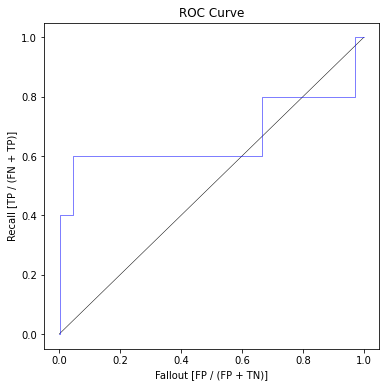

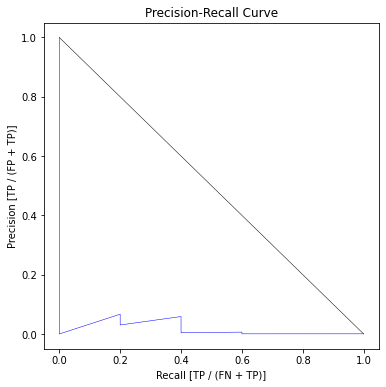

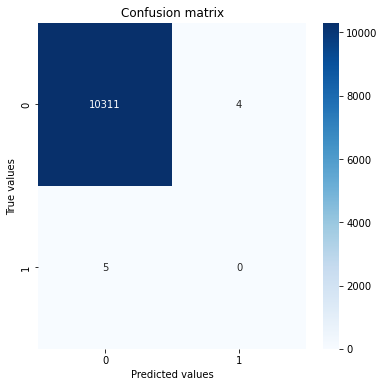

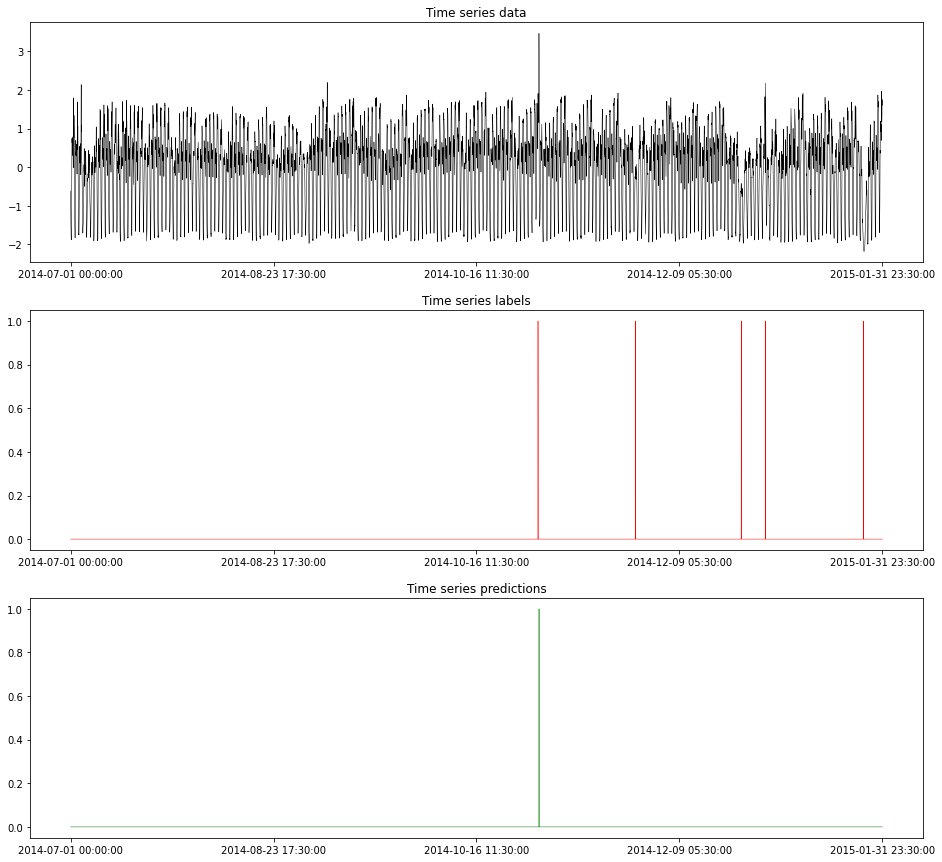

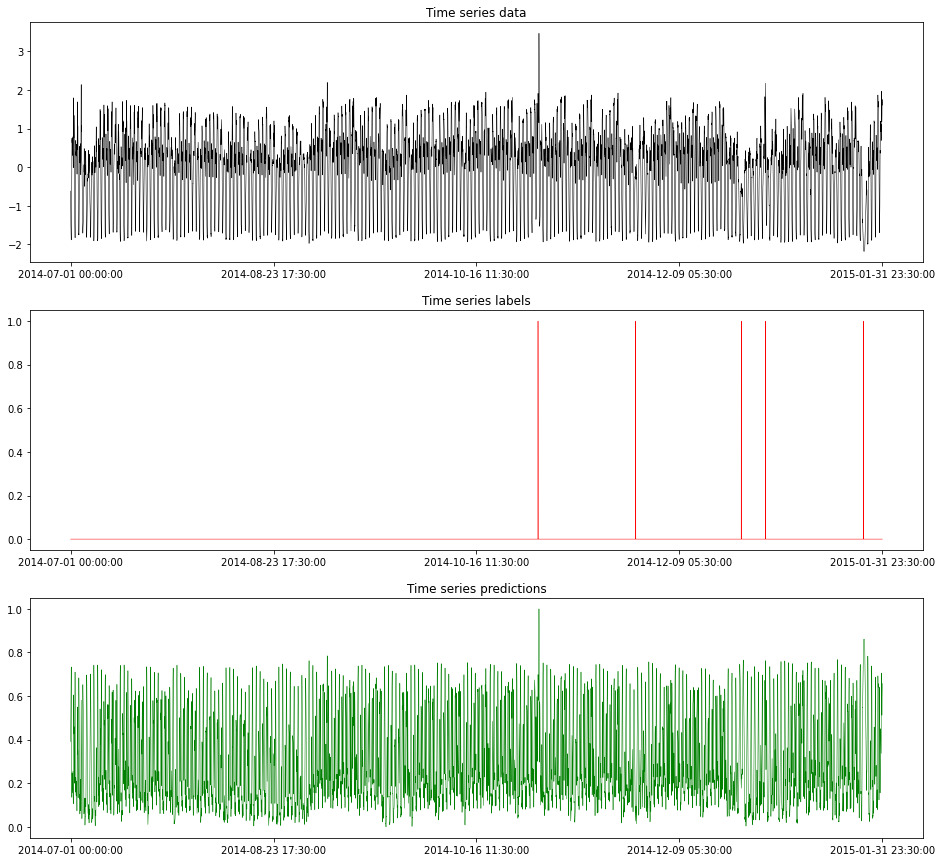

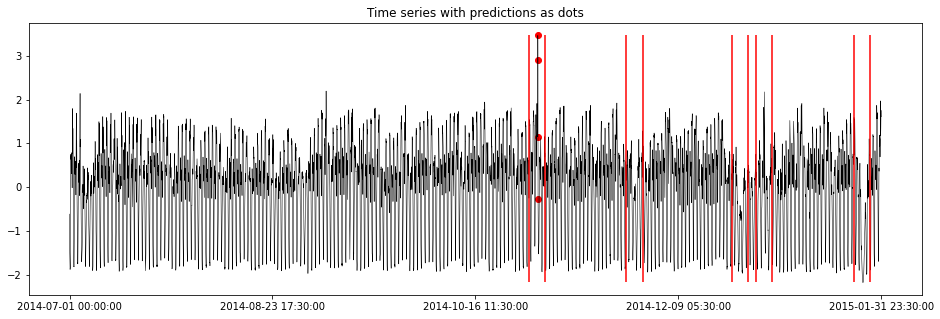

In [51]:
true_labels = data_test_labels
compute_metrics(true_labels, scores, labels, only_roc_auc=False)
make_metric_plots(dataframe, true_labels, scores, labels)

bars = get_bars_indices_on_test_df(all_df,
                                   dataframe,
                                   PURE_DATA_KEY,
                                   GROUND_WINDOWS_PATH)
plot_time_series_with_predicitons_bars(dataframe,
                                       labels,
                                       bars,
                                       pred_color='r')